## PRIZM Analysis Pipeline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from data_prep import DataPrep
from rfi_flagging import RFI_flagging
import helper_functions as hf
from gsm_data import GSMData, get_desired_frequencies
from data import get_ambient_temperatures, interpolate_temperature

## Load Data

In [4]:
instrument = '100MHz'
channel = 'NS'
year = '2021'

# Choose Calibration type:
    # 'raw' = antenna 
    # 'short' = antenna - short
    # 'res50' = (antenna - short) / (res50 - short)
    # 'res100' = (antenna - short) / (res100 - short)
    
# Optimal flagging with res50
calib_type = 'res50'

If getting data from the metadatabase:

In [ ]:
dataprep = DataPrep(instrument, channel, year)
data, lst, systime = dataprep(calibration_type=calib_type)

To save output of DataPrep:

In [ ]:
path2file = f'../Data/{year}/{instrument[:-3]}/{channel}/'
file_ending = f'_{year}_{instrument[:-3]}{channel}.npy'

arrays = [data, lst, systime]
names = ['data', 'lst', 'systime']

for i in range(len(names)):
    np.save(path2file + names[i] + file_ending, arrays[i])

If uploading data from saved NumPy files:

In [18]:
path2file = f'../Data/{year}/{instrument[:-3]}/{channel}/'
file_ending = f'_{year}_{instrument[:-3]}{channel}.npy'

with open(path2file + 'data' + file_ending, 'rb') as f:
    data = np.load(f)
with open(path2file + 'lst' + file_ending, 'rb') as f:
    lst = np.load(f)
with open(path2file + 'systime' + file_ending, 'rb') as f:
    systime = np.load(f)

freq = np.arange(0, 250, 250/4096)

/tmp/ipykernel_25195/4183682130.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data[tstart:tstop]), shading='nearest', cmap='jet', vmin=-1, vmax=2)
/tmp/ipykernel_25195/4183682130.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(np.linspace(0,250,4096), lst[tstart:tstop],


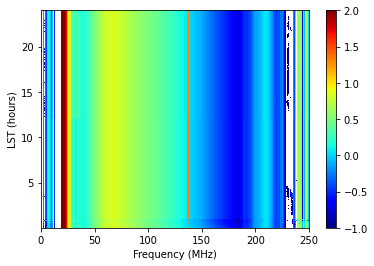

In [6]:
tstart = 26000
tstop = 37000

plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('unix time')
plt.pcolormesh(np.linspace(0,250,4096), systime[tstart:tstop], 
               np.log10(data[tstart:tstop]), shading='nearest', cmap='jet', vmin=-1, vmax=2)
plt.colorbar()
plt.show()

## Data truncation and RFI excision

In [5]:
# upload flag templates for ~ 75, 106, 112 MHz
f1 = [418, 1040, 930]
template1 = np.load('flag_templates/template_418_1040_930.npy')
f2 = [419, 1039, 931]
template2 = np.load('flag_templates/template_419_1039_931.npy')
f3 = [426, 1032, 938]
template3 = np.load('flag_templates/template_426_1032_938.npy')
f4 = [427, 1031, 939]
template4 = np.load('flag_templates/template_427_1031_939.npy')

In [7]:
# Parameters for flagging. 
if instrument == '100MHz':
    # truncate
    hpass=49
    lpass=136
    # flag by MAD from lst binned
    binsize=10
    thresh1=8
    # flag outliers in spectra
    window=8
    thresh2=0.001
    # flag template
    template=[[f1,template1], [f2,template2], [f3, template3], [f4,template4]]
    # flag FPGA & harmonics
    known_rfi=[60, 93.75, 125]
    width=0.3
    # cut high RFI frequency channels
    thresh3=0.5
    # cut high RFI spectra
    thresh4=0.02
    # cut high RFI days
    if channel == 'EW':
        bad_days=[12, 13, 14]
    elif channel == 'NS':
        bad_days=[5, 6, 7]
elif instrument == '70MHz':
    hpass=39
    lpass=91
    binsize=10
    thresh1=8
    window=8
    thresh2=0.001
    template=[[[f1[0]+164],template1], [[f2[0]+164],template2], [[f3[0]+164], template3], [[f4[0]+164],template4]]
    known_rfi=[60]
    width=0.3
    thresh3=0.5
    thresh4=0.01
    bad_days=[9,10]

In [8]:
RFI = RFI_flagging(data, freq, lst, systime)
data, freq = RFI(hpass, lpass, binsize, thresh1, window, thresh2, template, \
                              known_rfi, width, thresh3, thresh4, bad_days)

/gpfs/fs1/home/s/sievers/nasuyu/.virtualenvs/prizmenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/gpfs/fs1/home/s/sievers/nasuyu/.virtualenvs/prizmenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [9]:
np.savez('RFI_flagged/rfi_flagged_100NS_newfreq.npz', data=data, freq=freq)

In [10]:
np.savez('RFI_flagged/rfi_flagged_100NS.npz', data=data, freq=freq)

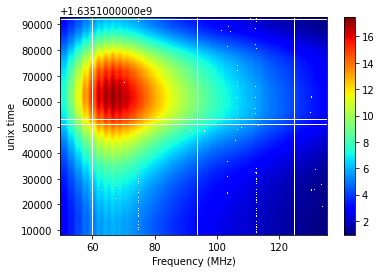

In [33]:
tstart = 26000
tstop = 37000

plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('unix time')
plt.pcolormesh(freq, systime[tstart:tstop], 
               data[tstart:tstop], shading='nearest', cmap='jet')
plt.colorbar()
plt.show()

## Binning

In [43]:
binsize_lst = 2 # min
binsize_f = 1 # MHz

# freq & lst bin
data_binned, freq_bins, lst_bins, freq_bin_inds, lst_bin_inds = hf.binning(data, freq, lst, binsize_f, binsize_lst, hpass+1, lpass-1)

# lst bin
data_binned, lst_bins, lst_bin_inds = hf.lst_binning(data, lst, binsize_lst)

/gpfs/fs0/scratch/s/sievers/nasuyu/PRIZM/prizm-analysis/helper_functions.py:37: RuntimeWarning: Mean of empty slice
  data_binned = np.array([np.nanmean(data[bin_inds == i], axis=0) for i in range(len(lst_bins))])


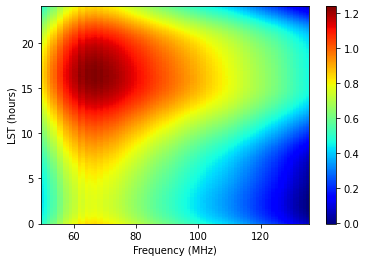

In [34]:
freq_bins = range(50,136)
lst_bins = np.linspace(0,24,720)

plt.figure()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.pcolormesh(freq_bins, lst_bins, 
               np.log10(data_binned), shading='nearest', cmap='jet')
plt.colorbar()
plt.show()

## Ambient Temperature

In [19]:
# path to 2021 data directories (the directories named by 1st 5 digits of unix time)
if instrument == '100MHz':
    path2dir = '/project/s/sievers/prizm/marion2022/prizm-100/data_100MHz/temperatures'
elif instrument == '70MHz':
    path2dir = '/project/s/sievers/prizm/marion2022/prizm-70/data_70MHz/temperatures'
    
T_amb, time_sys_start, time_sys_stop = get_ambient_temperatures(instrument, path2dir, verbose=False)

# calculate time stamp as average of start & stop times
time_sys = (time_sys_start + time_sys_stop) / 2

In [20]:
# interpolate to match antenna data time
T_amb_interp, temp_time_interp, interp_inds = interpolate_temperature(T_amb, time_sys, systime)

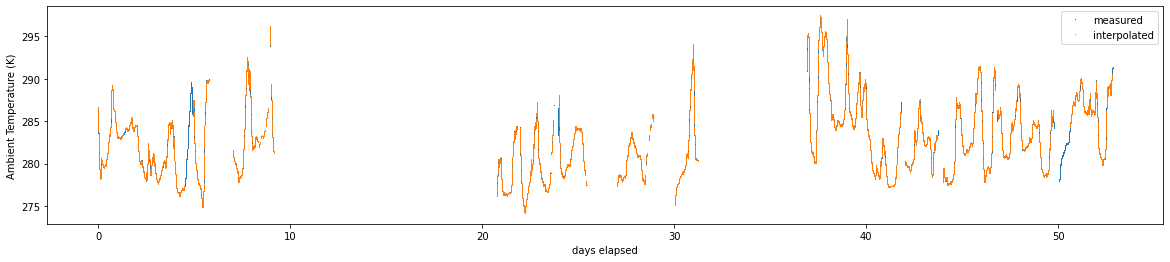

In [21]:
plt.figure(figsize=(20,4))
plt.ylabel('Ambient Temperature (K)')
plt.xlabel('days elapsed')
plt.plot((time_sys - time_sys[0])/24/3600, T_amb, ',', label='measured')
plt.plot((temp_time_interp - time_sys[0])/24/3600, T_amb_interp, ',', label='interpolated')
plt.legend()

In [8]:
np.savez(f'Temperature/T_ambient_{instrument}.npz', T_amb=T_amb, systime=time_sys)

## GSM

In [8]:
minperbin = 2

If loading GSM Temperatures from saved file:

In [16]:
with open(f'./GSM_averages/{instrument}_{channel}_GSM_average_{minperbin}min.npy', 'rb') as f:
    Tgsm = np.load(f)

If generating GSM Temperatures from pygdsm:

In [9]:
# horizon profile
SHAPES = np.load('horizon_profile.npz')
profile, az = SHAPES['profile'], SHAPES['azimuth']

In [11]:
gsm = GSMData(instrument, channel, minperbin, horizon=profile)
# model options are: GSM16, LFSS, Haslam (choose spectral index beta)
Tgsm = gsm(model='GSM16', beta=None, saved_maps=True, zerobin=0)

In [12]:
np.save('GSM_averages/100MHz_NS_GSM_average_2minbins_horizon_0align.npy', Tgsm)

In [ ]:
gsm = get_desired_frequencies(Tgsm, flow, fhigh)